In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
ROUND_NUMBER = 20 

In [2]:
df_original = pd.read_excel('./input_full.xlsx')
df_original = df_original[df_original['Date'].dt.month ==
                          10]  # Используем только данные за 4ый квартал
df_original = df_original[df_original['GDP, $bln']!=0] # Убираем ВВП == 0
df_original.reset_index(inplace=True)
df_original.head()
df_original.isna().sum()

index                                               0
Date                                                0
Country                                             0
Region                                              0
GDP, $bln                                           0
Net Dividends Paid By Nonfinancial Corporates       2
Dividends Paid Abroad                            2503
FPI into Domestic Equity LEVEL                   5115
FDI into Domestic Equity LEVEL                   3912
Domestic Companies MrkСap, $bln                  5205
dtype: int64

In [3]:
COLUMNS = {
    'date':
    'Date',
    'country':
    'Country',
    'region':
    'Region',
    'gdr':
    'GDP, $bln',
    'net_dividends_paid_by_nonfin_corp':
    'Net Dividends Paid By Nonfinancial Corporates',
    'dividends_paid_abroad':
    'Dividends Paid Abroad',
    'fpi_into_domestic_equity_level':
    'FPI into Domestic Equity LEVEL',
    'fdi_into_domestic_equity_level':
    'FDI into Domestic Equity LEVEL',
    'domestic_companies_mrk_cap':
    'Domestic Companies MrkСap, $bln',
    'domestic_companies_cap':
    'Domestic Companies Capitalization, $bln',
    'bop_implied_dividends_yield':
    'BOP-implied Dividends Yield, %',
    'net_dividends_paid_by_nonfin_corp_divide_gdp_interpolated':
    'Net Dividends Paid By Nonfinancial Corporates [INTERPOLATED] / GDR %',
    'dividends_paid_abroad_divide_gdp_interpolated':
    'Dividends Paid Abroad [INTERPOLATED] / GDR %',
    'fdi_into_domestic_equity_level_divide_gdp_interpolated':
    'FDI into Domestic Equity LEVEL [INTERPOLATED] / GDR %',
    'fpi_into_domestic_equity_level_divide_gdp_interpolated':
    'FPI into Domestic Equity LEVEL [INTERPOLATED] / GDR %',
    'domestic_companies_mrk_cap_divide_gdp_interpolated':
    'Domestic Companies MrkСap, $bln [INTERPOLATED] / GDR, %'
}
df = pd.DataFrame(columns=COLUMNS.keys())
for column, original_column in COLUMNS.items():
    df[column] = df_original.get(original_column, default=np.nan)
df.reset_index(inplace=True)
df.set_index(['index','date', 'region', 'country'], inplace=True)
df.head()
df.isna().sum()

gdr                                                             0
net_dividends_paid_by_nonfin_corp                               2
dividends_paid_abroad                                        2503
fpi_into_domestic_equity_level                               5115
fdi_into_domestic_equity_level                               3912
domestic_companies_mrk_cap                                   5205
domestic_companies_cap                                       6272
bop_implied_dividends_yield                                  6272
net_dividends_paid_by_nonfin_corp_divide_gdp_interpolated    6272
dividends_paid_abroad_divide_gdp_interpolated                6272
fdi_into_domestic_equity_level_divide_gdp_interpolated       6272
fpi_into_domestic_equity_level_divide_gdp_interpolated       6272
domestic_companies_mrk_cap_divide_gdp_interpolated           6272
dtype: int64

In [4]:
df['net_dividends_paid_by_nonfin_corp_divide_gdp_interpolated'] = (
    df['net_dividends_paid_by_nonfin_corp'] / df['gdr'])
df['dividends_paid_abroad_divide_gdp_interpolated'] = (
    df['dividends_paid_abroad'] / df['gdr'])
df['fdi_into_domestic_equity_level_divide_gdp_interpolated'] = (
    df['fdi_into_domestic_equity_level'] / df['gdr'])
df['fpi_into_domestic_equity_level_divide_gdp_interpolated'] = (
    df['fpi_into_domestic_equity_level'] / df['gdr'])
df['domestic_companies_mrk_cap_divide_gdp_interpolated'] = (
    df['domestic_companies_mrk_cap'] / df['gdr'])
df.isna().sum()

gdr                                                             0
net_dividends_paid_by_nonfin_corp                               2
dividends_paid_abroad                                        2503
fpi_into_domestic_equity_level                               5115
fdi_into_domestic_equity_level                               3912
domestic_companies_mrk_cap                                   5205
domestic_companies_cap                                       6272
bop_implied_dividends_yield                                  6272
net_dividends_paid_by_nonfin_corp_divide_gdp_interpolated       2
dividends_paid_abroad_divide_gdp_interpolated                2503
fdi_into_domestic_equity_level_divide_gdp_interpolated       3912
fpi_into_domestic_equity_level_divide_gdp_interpolated       5115
domestic_companies_mrk_cap_divide_gdp_interpolated           5205
dtype: int64

In [5]:
from scipy.interpolate import interp1d
from scipy import arange, array, exp

def check_possible_for_trand_line(lst: pd.Series,
                                  count_in_a_row: int = 5) -> bool:
    """ Проверяем возможно-ли построить линию тренда (требуется count_in_a_row точек подряд) """
    if len([x for x in lst.rolling(count_in_a_row)
            if 0 == x.isnull().sum()]) == 0:
        return False
    return True



def my_interpolate(original_lst):
    original_lst = original_lst
    x1, x2 = 1, 5
    def pointwise(x0):
        direction = get_direction(x0)
        if direction is not None and np.isnan(original_lst.loc[x0].values):
            f_x1 = original_lst.loc[x0 - x1 * direction].values
            f_x2 = original_lst.loc[x0 - x2 * direction].values
            result = max(
                f_x1 + (0 - x1) * ((f_x2 - f_x1) / (x2 - x1)), 0)
            original_lst.loc[x0] = result

    def get_direction(x0):
        if original_lst.loc[x0 - x2:x0].isnull().sum() == 0 and x0 - x2 >= original_lst.index.get_level_values(0).min():
            return 1
        if original_lst.loc[x0 + 1:x0 + x2 + 1].isnull().sum(
        ) == 0 and x0 + x2 + 1 < original_lst.index.get_level_values(0).max():
            return -1
        return None

    def ufunclike(xs):
        list(map(pointwise, xs))
    return ufunclike





def set_values_by_line_trand(df: pd.DataFrame, column_name: str) -> None:
    """ Проставляет значения в колонках columns по алгоритму линейной интер/экстраполяции """
    df.reset_index(inplace=True)
    df.set_index(['index','date', 'region', 'country'], inplace=True)
    def f(dfGroupBy):
        lst = dfGroupBy[column_name]
        if check_possible_for_trand_line(lst) and lst.isna().sum() > 0:
            f_x = my_interpolate(lst)
            f_x(lst[lst.isna()].index.get_level_values(0).to_list()[::1])
            f_x(lst[lst.isna()].index.get_level_values(0).to_list()[::-1])
            df[column_name].fillna(lst, inplace=True)
            
    df.groupby('country').apply(f)

set_values_by_line_trand(df, "dividends_paid_abroad_divide_gdp_interpolated")

set_values_by_line_trand(
    df, "fdi_into_domestic_equity_level_divide_gdp_interpolated")

set_values_by_line_trand(
    df, "fpi_into_domestic_equity_level_divide_gdp_interpolated")

set_values_by_line_trand(df,
                         "domestic_companies_mrk_cap_divide_gdp_interpolated")
df.head()
df.isna().sum()

(0, Timestamp('1980-10-01 00:00:00'), 'North America', 'USA')


gdr                                                             0
net_dividends_paid_by_nonfin_corp                               2
dividends_paid_abroad                                        2503
fpi_into_domestic_equity_level                               5115
fdi_into_domestic_equity_level                               3912
domestic_companies_mrk_cap                                   5205
domestic_companies_cap                                       6272
bop_implied_dividends_yield                                  6272
net_dividends_paid_by_nonfin_corp_divide_gdp_interpolated       2
dividends_paid_abroad_divide_gdp_interpolated                1365
fdi_into_domestic_equity_level_divide_gdp_interpolated       1912
fpi_into_domestic_equity_level_divide_gdp_interpolated       3997
domestic_companies_mrk_cap_divide_gdp_interpolated           4525
dtype: int64

In [6]:
def get_means_by_year(column_name: str,
                      df_original: pd.DataFrame) -> pd.Series:
    """ Получение среднего значение по региону по годам """
    tmp = df_original.groupby(['region', 'date']).mean()[column_name]
    return pd.Series(data=tmp, dtype='float64')


def set_values_by_mean_years(df: pd.DataFrame, column_name: str):
    """ Проставляет значения в колонках columns используя среднее значение за год по всему региону"""
    avgs_by_year = get_means_by_year(column_name, df)
    df.reset_index(inplace=True)
    df.set_index(['region','date', 'index', 'country'], inplace=True)
    df[column_name].fillna(avgs_by_year, inplace=True)


set_values_by_mean_years(df, 'dividends_paid_abroad_divide_gdp_interpolated')
set_values_by_mean_years(
    df, 'fdi_into_domestic_equity_level_divide_gdp_interpolated')
set_values_by_mean_years(
    df, 'fpi_into_domestic_equity_level_divide_gdp_interpolated')
set_values_by_mean_years(df,
                         'domestic_companies_mrk_cap_divide_gdp_interpolated')

df.head()
df.isna().sum()

gdr                                                             0
net_dividends_paid_by_nonfin_corp                               2
dividends_paid_abroad                                        2503
fpi_into_domestic_equity_level                               5115
fdi_into_domestic_equity_level                               3912
domestic_companies_mrk_cap                                   5205
domestic_companies_cap                                       6272
bop_implied_dividends_yield                                  6272
net_dividends_paid_by_nonfin_corp_divide_gdp_interpolated       2
dividends_paid_abroad_divide_gdp_interpolated                   8
fdi_into_domestic_equity_level_divide_gdp_interpolated         74
fpi_into_domestic_equity_level_divide_gdp_interpolated        170
domestic_companies_mrk_cap_divide_gdp_interpolated            256
dtype: int64

In [7]:
def get_mean_by_region(df_original: pd.DataFrame,
                       column_name: str) -> pd.Series:
    """ Получение среднего значение по региону """
    tmp = df_original.groupby(['region']).mean()[column_name]
    
    return pd.Series(data=tmp, dtype='float64')


def set_values_by_mean_region(df: pd.DataFrame, column_name: str) -> None:
    """ Проставляет значения в колонках columns используя среднее значение за все время по всему региону"""
    avgs_by_region = get_mean_by_region(df, column_name)
    df.reset_index(inplace=True)
    df.set_index(['region'], inplace=True)
    df[column_name].fillna(avgs_by_region, inplace=True)
    df.reset_index(inplace=True)
    df.set_index(['region','date', 'index', 'country'], inplace=True)

set_values_by_mean_region(df, 'dividends_paid_abroad_divide_gdp_interpolated')
set_values_by_mean_region(
    df, 'fdi_into_domestic_equity_level_divide_gdp_interpolated')
set_values_by_mean_region(
    df, 'fpi_into_domestic_equity_level_divide_gdp_interpolated')
set_values_by_mean_region(
    df, 'domestic_companies_mrk_cap_divide_gdp_interpolated')
df.head()
df.isna().sum()

gdr                                                             0
net_dividends_paid_by_nonfin_corp                               2
dividends_paid_abroad                                        2503
fpi_into_domestic_equity_level                               5115
fdi_into_domestic_equity_level                               3912
domestic_companies_mrk_cap                                   5205
domestic_companies_cap                                       6272
bop_implied_dividends_yield                                  6272
net_dividends_paid_by_nonfin_corp_divide_gdp_interpolated       2
dividends_paid_abroad_divide_gdp_interpolated                   0
fdi_into_domestic_equity_level_divide_gdp_interpolated          0
fpi_into_domestic_equity_level_divide_gdp_interpolated        128
domestic_companies_mrk_cap_divide_gdp_interpolated            128
dtype: int64

In [8]:
df['dividends_paid_abroad'].fillna(
    value=df['dividends_paid_abroad_divide_gdp_interpolated'] * df['gdr'],
    inplace=True)
df['fdi_into_domestic_equity_level'].fillna(
    value=df['fdi_into_domestic_equity_level_divide_gdp_interpolated'] *
    df['gdr'],
    inplace=True)
df['fpi_into_domestic_equity_level'].fillna(
    value=df['fpi_into_domestic_equity_level_divide_gdp_interpolated'] *
    df['gdr'],
    inplace=True)
df['domestic_companies_mrk_cap'].fillna(
    value=df['domestic_companies_mrk_cap_divide_gdp_interpolated'] * df['gdr'],
    inplace=True)
df['domestic_companies_cap'].fillna(
    value=df[['domestic_companies_mrk_cap', 'fpi_into_domestic_equity_level'
              ]].max(axis=1) + df['fdi_into_domestic_equity_level'].fillna(0),
    inplace=True)
df['bop_implied_dividends_yield'].fillna(
    value=df['dividends_paid_abroad'] / (df['fdi_into_domestic_equity_level'].fillna(0) +
                                         df['fpi_into_domestic_equity_level'].fillna(0)),
    inplace=True)
df.isna().sum()

gdr                                                            0
net_dividends_paid_by_nonfin_corp                              2
dividends_paid_abroad                                          0
fpi_into_domestic_equity_level                               128
fdi_into_domestic_equity_level                                 0
domestic_companies_mrk_cap                                   128
domestic_companies_cap                                       128
bop_implied_dividends_yield                                   35
net_dividends_paid_by_nonfin_corp_divide_gdp_interpolated      2
dividends_paid_abroad_divide_gdp_interpolated                  0
fdi_into_domestic_equity_level_divide_gdp_interpolated         0
fpi_into_domestic_equity_level_divide_gdp_interpolated       128
domestic_companies_mrk_cap_divide_gdp_interpolated           128
dtype: int64

In [9]:
set_values_by_line_trand(
    df, 'net_dividends_paid_by_nonfin_corp_divide_gdp_interpolated')
df['net_dividends_paid_by_nonfin_corp'].fillna(
    value=df['net_dividends_paid_by_nonfin_corp_divide_gdp_interpolated'] *
    df['gdr'],
    inplace=True)
df['net_dividends_paid_by_nonfin_corp'].fillna(
    value=df['domestic_companies_cap'] * df['bop_implied_dividends_yield'] -
    df['dividends_paid_abroad'],
    inplace=True)
df.isna().sum()

gdr                                                            0
net_dividends_paid_by_nonfin_corp                              0
dividends_paid_abroad                                          0
fpi_into_domestic_equity_level                               128
fdi_into_domestic_equity_level                                 0
domestic_companies_mrk_cap                                   128
domestic_companies_cap                                       128
bop_implied_dividends_yield                                   35
net_dividends_paid_by_nonfin_corp_divide_gdp_interpolated      0
dividends_paid_abroad_divide_gdp_interpolated                  0
fdi_into_domestic_equity_level_divide_gdp_interpolated         0
fpi_into_domestic_equity_level_divide_gdp_interpolated       128
domestic_companies_mrk_cap_divide_gdp_interpolated           128
dtype: int64

In [10]:
t = df.copy().reset_index()
t.to_excel('./output.xlsx')

<AxesSubplot:xlabel='date'>

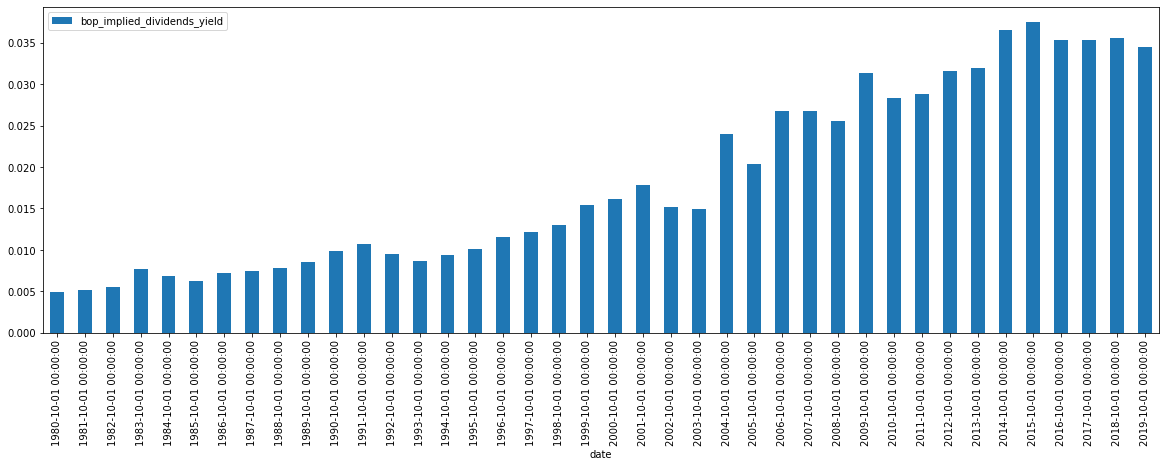

In [11]:
# Указать страну
country = 'USA'
# Указать параметр(столбец)
column = 'bop_implied_dividends_yield'

output_data = pd.read_excel('./output.xlsx')
tmp = output_data[output_data['country'] == country]
tmp = tmp[['date', f'{column}']]
tmp.plot.bar(x='date', figsize=(20, 6))